#  This is Lab 1 executable file
This file contains the program code that is the solution to the tasks from the file [lab_1_task.txt](https://github.com/vandosik/M-M-MSA/blob/master/Lab_1/lab_1_task.txt).
## Authors
* Ivan Dubinin: [vandosik](https://github.com/vandosik)
* Alexey Grandilevskii: [zer0deck](https://github.com/zer0deck)
* Mikhail Sorokin: [Mikha1lSorokin](https://github.com/Mikha1lSorokin)

In [562]:
# libs initialization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from scipy.optimize import curve_fit, minimize
import seaborn as sns

In [563]:
# Dataset initialization
path_to_file = '../Datasets/GameStats.csv'
source_df = pd.read_csv(path_to_file, engine='python')
source_df.head(5)

,Date,Level,NumBlocks,IsWin,ElapsedTime,Score,Accuracy
0,9/7/2019 2:43:29 PM,520,30,False,1.579998,150,0.0
1,9/7/2019 2:44:46 PM,520,30,False,3.805001,100,0.0
2,9/7/2019 2:59:20 PM,520,30,False,1.783006,50,0.0
3,9/7/2019 2:59:28 PM,520,30,True,0.263020,0,0.0
4,9/7/2019 2:59:48 PM,520,30,True,3.318019,50,0.0


Date:        date and time the game was auto-played

Level:       the 3-digit number is an estimate of the difficulty from a previous run

NumBlocks:   how many blocks have to be broken to win the level

IsWin:       True if autoplay broke all the blocks, False if the ball fell past the paddle

ElapsedTime: Seconds until either won or lost (game is played at 4x speed, so multiply by 4 to get an estimate of how long a human might play it)

Score:       total score when the game was won or lost

Accuracy:    the autoplay is tuned with a randomly-chosen accuracy. Higher numbers are more likely to win;

In [564]:
# Select column

# col_names = ['Date',	'Level',	'NumBlocks',	'IsWin',	'ElapsedTime',	'Score',	'Accuracy']
col_names = list(source_df.columns)
# col_name = col_names[4]
col_name = "Accuracy"
# col_name = "ElapsedTime"
# col_name = "Score"
# col_name = "NumBlocks"


In [565]:
# Remove outliers
if True: # one way
    q_low = source_df[col_name].quantile(0.005)
    q_hi  = source_df[col_name].quantile(0.995)

    source_df = source_df[(source_df[col_name] < q_hi) & (source_df[col_name] > q_low)]
else: # other way
    source_df[(np.abs(scipy.stats.zscore(source_df)) < 3).all(axis=1)]

Text(0, 0.5, 'Column val')

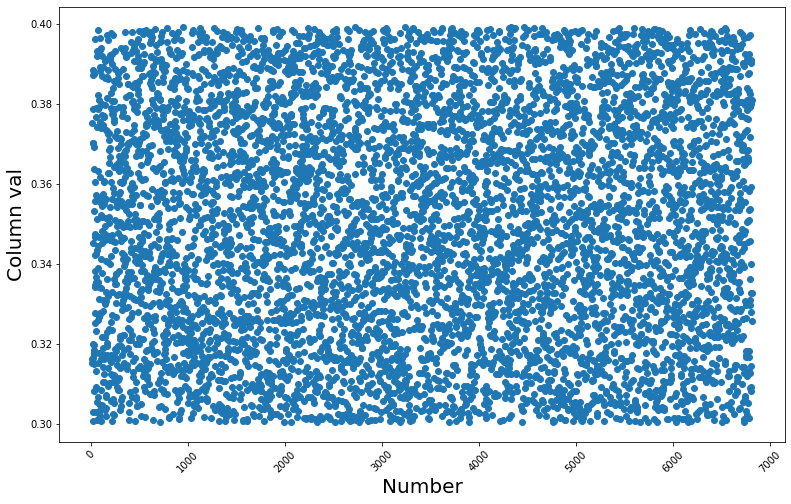

In [566]:
# Display our data
plt.figure(figsize=(13, 8))

plt.scatter(source_df.index, source_df[col_name])
plt.xticks(rotation=45)

plt.xlabel(u'Number', fontsize = 20)
plt.ylabel(u'Column val', fontsize = 20)

## Exercise №2

No handles with labels found to put in legend.


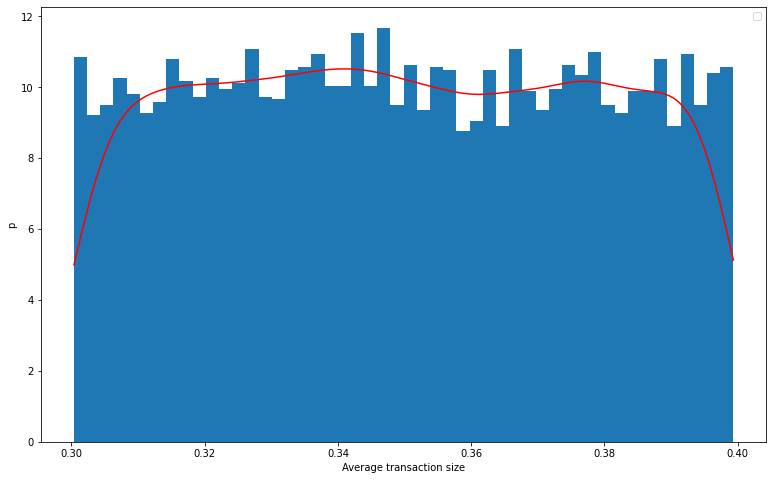

In [567]:
#Plotting a histogram and kernel density estimate
plt.figure(figsize=(13, 8))

kernel = scipy.stats.gaussian_kde(source_df[col_name])

min_amount, max_amount = source_df[col_name].min(), source_df[col_name].max()
x = np.linspace(min_amount, max_amount, len(source_df)) # by defaul 50 items
kde_values = kernel(x)

# sns.histplot(source_df[col_name], kde=False, stat="density", label=f'Average transaction size in rubles')
# Draw unnormed histogramm
hist_data = plt.hist(source_df[col_name], density=True, bins=50)

# print(hist_vals)
plt.plot(x, kde_values, color="r")

plt.ylabel('p')
plt.xlabel('Average transaction size')

plt.legend()
plt.show()

## Exercise №3

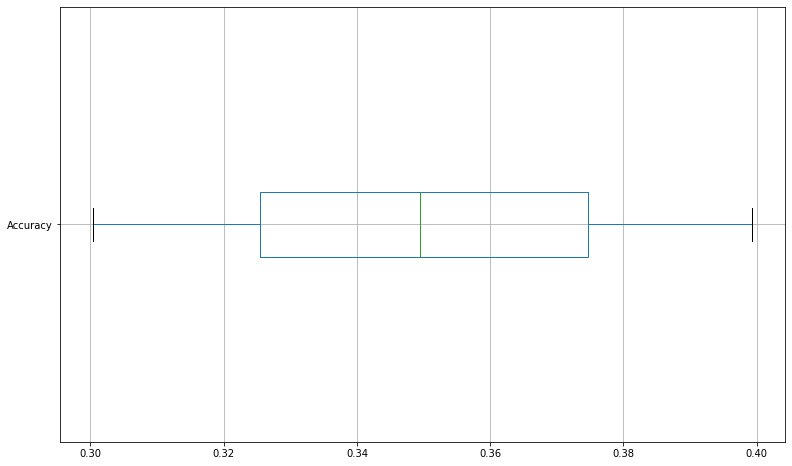

In [568]:
plt.figure(figsize=(13, 8))
# Calculation of sample mean, variance, standard deviation, median
mean = source_df[col_name].mean()
var = source_df[col_name].var()
std = source_df[col_name].std()
median = source_df[col_name].median()
# Box plot
boxplot = source_df.boxplot(column=[col_name], whis=3., vert=False) # defaul whis is 1.5 (to many outliers there)
# boxplot = source_df.boxplot(column=['Accuracy'])

## Exercise №4

MLE:  (0.3003654, 0.0990025)
LSE:  [0.29958004 0.09897135]


C:\Users\vando\AppData\Local\Temp/ipykernel_16076/1636651166.py:45: RuntimeWarning: divide by zero encountered in double_scalars
  ret_vals = np.array([1./(scale)] * len(arg_x))


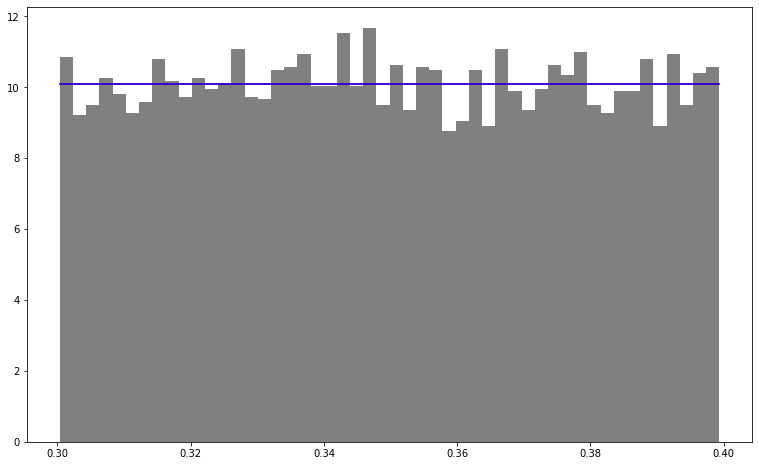

In [569]:
plt.figure(figsize=(13, 8))
# Determination of the parameters of the distribution 

hist_data = plt.hist(source_df[col_name], density=True, bins=50, color='grey')
x = np.linspace(min_amount, max_amount)

if col_name == 'ElapsedTime':
    # The lognorm distribution parameters are determined using the fit function based on the maximum likelihood method
    mle_params = scipy.stats.lognorm.fit(source_df[col_name])
    print("MLE: ", mle_params)
    pdf_mle = scipy.stats.lognorm.pdf(x, *mle_params)

elif col_name == 'Accuracy':
    mle_params = scipy.stats.uniform.fit(source_df[col_name])
    print("MLE: ", mle_params)
    pdf_mle = scipy.stats.uniform.pdf(x, *mle_params)


plt.plot(x, pdf_mle, color='r')

#  The distribution parameters are determined using the fit function based on least squares method
# Prepare data for least squares
hist_bins = hist_data[1][:-1]  # remove last element
delta = hist_bins[1]-hist_bins[0]
hist_bins += delta / 2 # Take centres of bins
# print(hist_bins)
hist_vals = hist_data[0] # Get the height of bins for least squares
# print(hist_vals)

if col_name == 'ElapsedTime':
    def lognorm(arg_x, s, loc, scale):
        return scipy.stats.lognorm.pdf(arg_x, s, loc, scale)
    
    def lst_sqrs(par_ar, gt, x):
        s, loc, scale = par_ar
        return sum((gt - lognorm(x, s, loc, scale))**2)

    lse_params = minimize(lst_sqrs, [1.1, 1.1, 1.1], method = 'Nelder-Mead', args=(hist_vals, hist_bins), tol=0.001, options={'disp': True})
    print("LSE: ",lse_params.x)
    pdf_lsm = scipy.stats.lognorm.pdf(x, *lse_params.x)

elif col_name == 'Accuracy':

    def uniform(arg_x, loc, scale):
        ret_vals = np.array([1./(scale)] * len(arg_x))

        ret_vals[arg_x < loc] = 0
        ret_vals[arg_x > (loc + scale)] = 0

        return ret_vals

    def lst_sqrs(par_ar, gt, x):
        loc, scale = par_ar
        return sum((gt - uniform(x, loc, scale))**2)

    lse_params = minimize(lst_sqrs, [0., 10.], method = 'Nelder-Mead', args=(hist_vals, hist_bins), tol=0.001)
    print("LSE: ", lse_params.x)
    pdf_lsm = scipy.stats.uniform.pdf(hist_bins, *lse_params.x)

plt.plot(x, pdf_lsm, color='b')



## Exercise №5

In [570]:
# Print Gained distribs by MLE and LSE



## Exercise №6

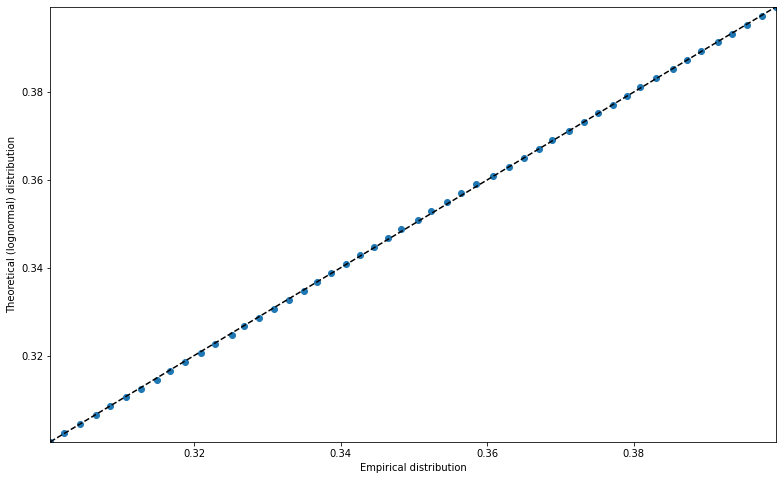

In [571]:
# Plotting a quantile biplot for empirical and theoretical (lognormal) distribution

# Calculation of quantiles
percs = np.linspace(0, 100, 50)
qn_real = np.percentile(source_df[col_name], percs)

if col_name == 'ElapsedTime':
    qn_theor = scipy.stats.lognorm.ppf(percs / 100.0, *mle_params)
elif col_name == 'Accuracy':
    qn_theor = scipy.stats.uniform.ppf(percs / 100.0, *mle_params)



# Building a quantile biplot
plt.figure(figsize=(13, 8))
plt.plot(qn_real, qn_theor, ls="", marker="o", markersize=6)
plt.plot(x, x, color="k", ls="--")
plt.xlim(min_amount, max_amount)
plt.ylim(min_amount, max_amount)
plt.xlabel(f'Empirical distribution')
plt.ylabel('Theoretical (lognormal) distribution')

plt.show()

## Exercise №7

In [572]:
# Calculation of the Kolmogorov-Smirnov test, Cramér-von Mises test  and chi-square (Pirson test?)

if col_name == 'ElapsedTime':
    ks = scipy.stats.kstest(source_df[col_name], 'lognorm', mle_params, N=100)
    cvm = scipy.stats.cramervonmises(source_df[col_name], 'lognorm', mle_params)
    # chi2 = scipy.stats.chisquare(source_df[col_name])

elif col_name == 'Accuracy':
    ks = scipy.stats.kstest(source_df[col_name], 'uniform', mle_params, N=100)
    cvm = scipy.stats.cramervonmises(source_df[col_name], 'uniform', mle_params)
    # chi2 = scipy.stats.chisquare(source_df[col_name])

print(ks)
print(cvm)
print(chi2)

KstestResult(statistic=0.006834426967721685, pvalue=0.90887604551172)
CramerVonMisesResult(statistic=0.04398393727507487, pvalue=0.9116320502433617)
Power_divergenceResult(statistic=15.666901374626267, pvalue=1.0)
